In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRFRegressor
from sklearn.linear_model import SGDRegressor, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
#pandas option to display max columns
pd.set_option('display.max_columns',None)
# Set Matplotlib defaults Style
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10
    )
sns.set_palette('plasma', n_colors=None, desat=None, color_codes=False)
import warnings
warnings.simplefilter("ignore")

In [2]:
df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')


In [3]:
print("train data : {}".format(df.shape))
print("test data : {}".format(df_test.shape))
df.head()

train data : (188533, 13)
test data : (125690, 12)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
test_ids = df_test['id'].copy()

In [5]:
df.drop("id",axis=1, inplace=True)
df_test.drop("id",axis=1, inplace=True)
df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [6]:
df.duplicated().sum()

0

In [7]:
#% of null by colums abs
(df.isnull().sum())/df.shape[0]*100

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [8]:
df['clean_title'].fillna('Unknown', inplace=True)
df_test['clean_title'].fillna('Unknown', inplace=True)

In [9]:
df['fuel_type'] = df.groupby(['model', 'model_year'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
df_test['fuel_type'] = df_test.groupby(['model', 'model_year'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [10]:
df['accident'] = df.groupby(['model', 'model_year'])['accident'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
df_test['accident'] = df_test.groupby(['model', 'model_year'])['accident'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

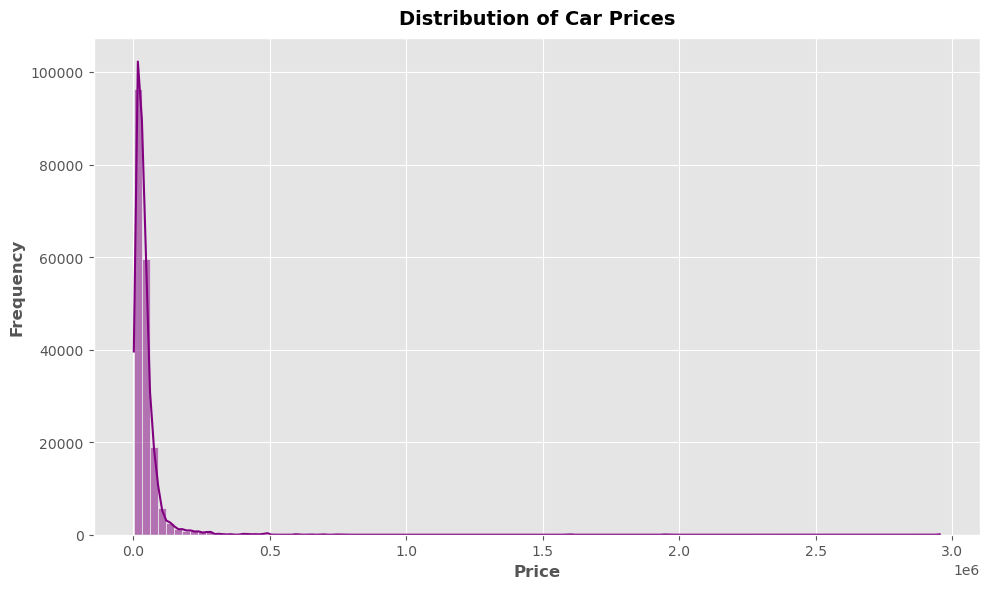

In [11]:
# Distribution of car prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=100, color='purple')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


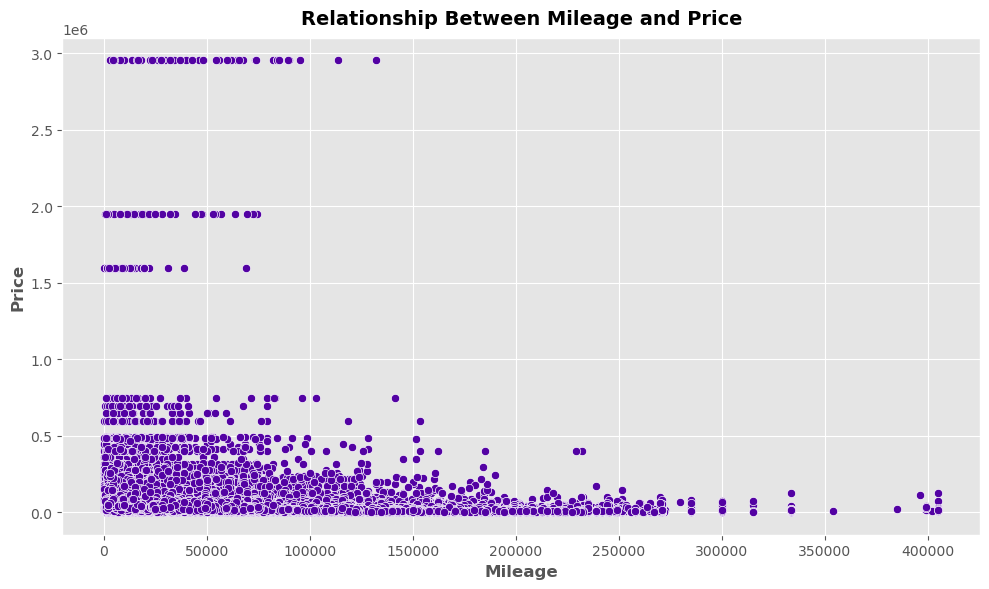

In [12]:
# Scatter plot of mileage vs price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['milage'], y=df['price'])
plt.title('Relationship Between Mileage and Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()


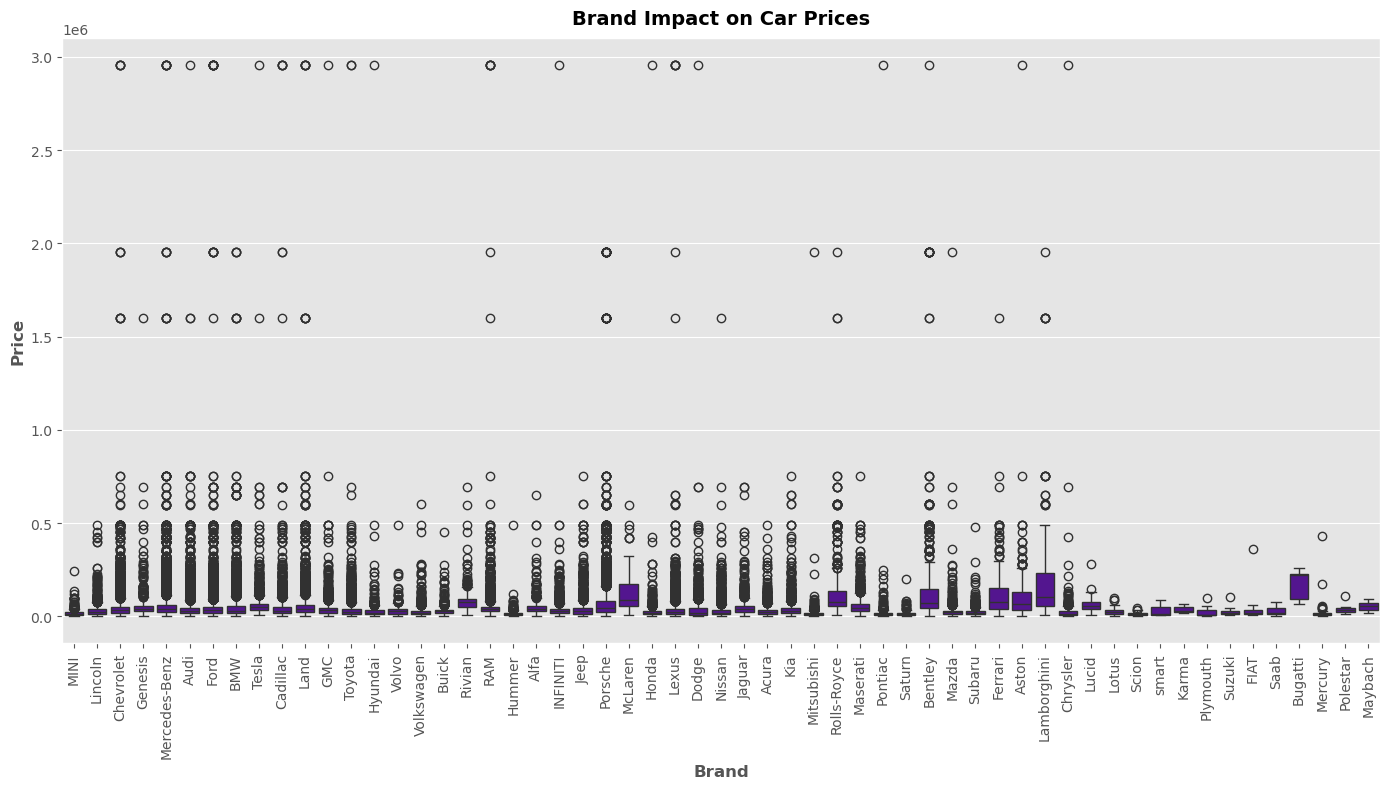

In [13]:
# Box plot for brand vs price
plt.figure(figsize=(14, 8))
sns.boxplot(x='brand', y='price', data=df)
plt.title('Brand Impact on Car Prices')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


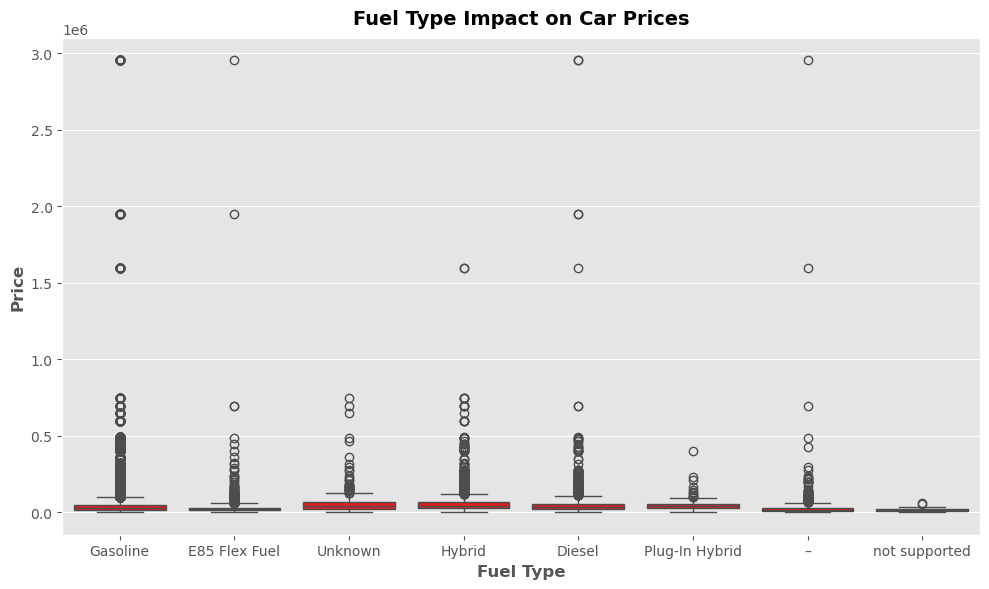

In [14]:
# Box plot for fuel_type vs price
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=df, color='red')
plt.title('Fuel Type Impact on Car Prices')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()


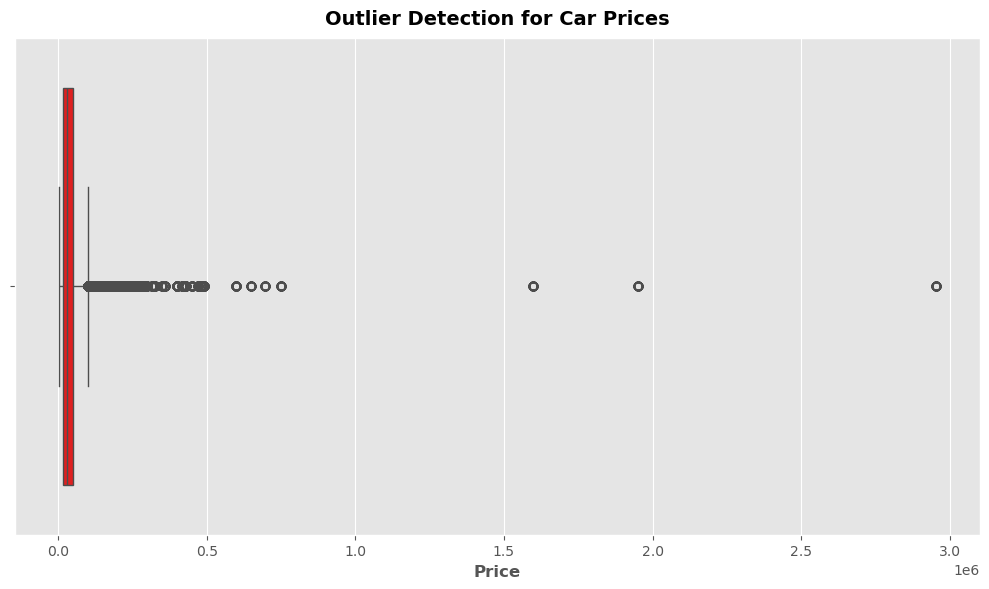

In [15]:
# Box plot to detect outliers in the price variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'], color='red')
plt.title('Outlier Detection for Car Prices')
plt.xlabel('Price')
plt.show()


In [16]:
current_year = datetime.now().year
df['car_age'] = current_year - df['model_year']
df_test['car_age'] = current_year - df_test['model_year']
df.drop('model_year', axis=1, inplace=True)
df_test.drop('model_year', axis=1, inplace=True)

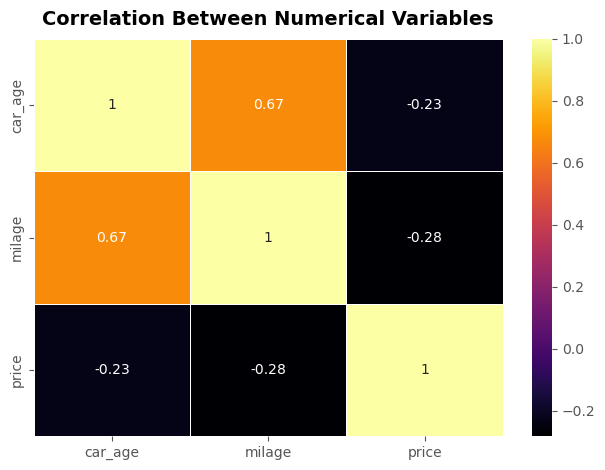

In [17]:
# Correlation heatmap for numerical variables
corr = df[['car_age', 'milage', 'price']].corr()
sns.heatmap(corr, annot=True, cmap='inferno', linewidths=0.5)
plt.title('Correlation Between Numerical Variables')
plt.show()


In [45]:
#le shape de df
print(df.shape)
#pour voir les valeurs uniques 
dist=df.describe(include='O').T
dist[8:2]

(188533, 10)


,count,unique,top,freq


In [19]:
print(df_test.shape)
df_test.describe(include='O').T

(125690, 11)


,count,unique,top,freq
brand,125690,55,Ford,15265
model,125690,1891,F-150 XLT,1923
fuel_type,125690,8,Gasoline,113173
engine,125690,1117,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,2189
transmission,125690,52,A/T,33132
ext_col,125690,317,Black,32370
int_col,125690,156,Black,71613
accident,125690,3,None reported,97671
clean_title,125690,2,Yes,111451


In [20]:
# Target encoding for 'model'
mean_price_per_model = df.groupby('model')['price'].mean()
df['model'] = df['model'].map(mean_price_per_model)
df_test['model'] = df_test['model'].map(mean_price_per_model)

# Extract engine power and cylinder
df['engine_power'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
df_test['engine_power'] = df_test['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

df['engine_cylinder'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
df_test['engine_cylinder'] = df_test['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)

# Remove the 'engine' column after extraction
df.drop('engine', axis=1, inplace=True)
df_test.drop('engine', axis=1, inplace=True)

# Regroup rare colors in 'ext_col' and 'int_col'
color_threshold = 100  # Adjust the threshold based on the dataset
ext_color_counts = df['ext_col'].value_counts()
rare_ext_colors = ext_color_counts[ext_color_counts < color_threshold].index
df['ext_col'] = df['ext_col'].replace(rare_ext_colors, 'Other')
df_test['ext_col'] = df_test['ext_col'].replace(rare_ext_colors, 'Other')

int_color_counts = df['int_col'].value_counts()
rare_int_colors = int_color_counts[int_color_counts < color_threshold].index
df['int_col'] = df['int_col'].replace(rare_int_colors, 'Other')
df_test['int_col'] = df_test['int_col'].replace(rare_int_colors, 'Other')

# Remove the original columns after processing
df.drop(['model', 'ext_col', 'int_col'], axis=1, inplace=True)
df_test.drop(['model', 'ext_col', 'int_col'], axis=1, inplace=True)

# Verify the shape of the resulting datasets
print(f"Shape of df after transformation: {df.shape}")
print(f"Shape of df_test after transformation: {df_test.shape}")


Shape of df after transformation: (188533, 10)
Shape of df_test after transformation: (125690, 9)


In [21]:
# Remplacer les valeurs nulles par la moyenne
df['engine_power'].fillna(df['engine_power'].mean(), inplace=True)
df_test['engine_power'].fillna(df_test['engine_power'].mean(), inplace=True)

df['engine_cylinder'].fillna(df['engine_cylinder'].mean(), inplace=True)
df_test['engine_cylinder'].fillna(df_test['engine_cylinder'].mean(), inplace=True)


In [22]:
# Séparer les colonnes numériques et catégorielles
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()

# Afficher les résultats
print("Categorical columns: ", categorical_columns)
print("Numerical columns: ", numerical_columns)


Categorical columns:  ['brand', 'fuel_type', 'transmission', 'accident', 'clean_title']
Numerical columns:  ['milage', 'price', 'car_age', 'engine_power', 'engine_cylinder']


In [23]:
# Enlever la variable cible 'price' des colonnes numériques
numerical_columns.remove('price')

In [24]:
# Séparation des features et de la cible
X = df.drop(columns=['price']) 
y = df['price']  # Variable cible

In [25]:
y, lambda_ = boxcox(y)

In [26]:
# Appliquer RobustScaler aux colonnes numériques dans train
scaler = RobustScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [27]:
## Encoder les colonnes catégorielles avec pd.get_dummies dans train
data_encoded = pd.get_dummies(X[categorical_columns], prefix=categorical_columns)

In [28]:
# Concaabsténer les colonnes numériques et encodées dans train et test
X = pd.concat([X[numerical_columns], data_encoded], axis=1)
X.shape

(188533, 126)

In [29]:
# Appliquer les mêmes transformations sur df_test
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns]) 
df_test_encoded = pd.get_dummies(df_test[categorical_columns], prefix=categorical_columns)
df_test = pd.concat([df_test[numerical_columns], df_test_encoded], axis=1)


In [30]:
# Aligner les colonnes entre df_encoded et df_test_encoded
X, df_test = X.align(df_test, join='left', axis=1, fill_value=0)

In [31]:
# s'assurer que les X et df_test on les memes shape
print("X shape : {}".format(X.shape))
print("test data shape : {}".format(df_test.shape))

X shape : (188533, 126)
test data shape : (125690, 126)


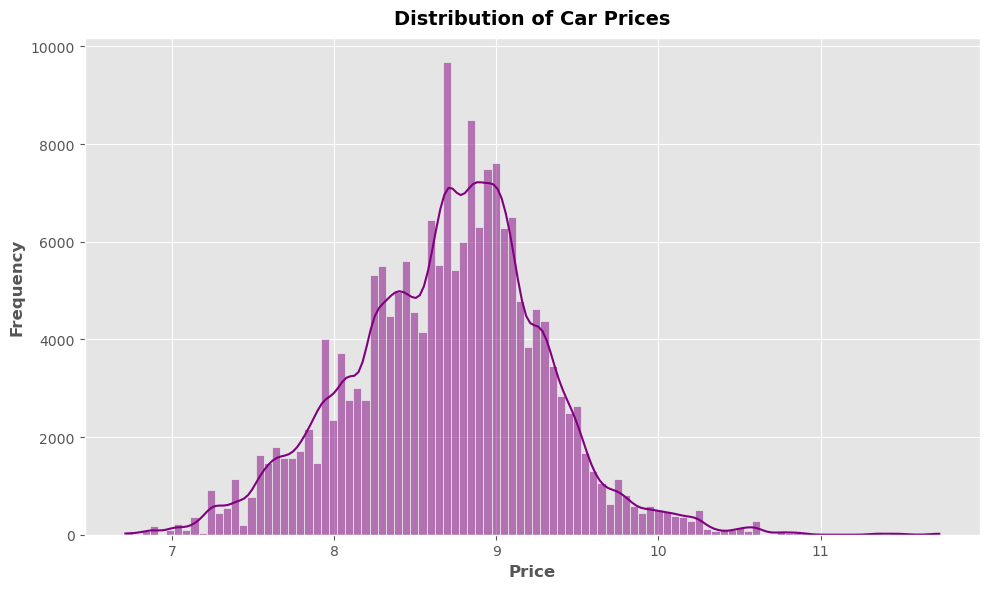

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=100, color='purple')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [33]:
# Diviser les données en ensemble d'entraînement et de validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# List of regression models to test
models = [
    KNeighborsRegressor(), 
    SGDRegressor(max_iter=1000, tol=1e-3), 
    Lasso(), 
    Ridge(), 
    CatBoostRegressor(silent=True), 
    XGBRFRegressor(),
    LGBMRegressor(boosting_type='rf', bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8)
] # randomforest 


In [ ]:
for model in models:
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Prédire sur le jeu de test
    y_pred_transformed = model.predict(X_test)
    
    # Inverser la transformation Box-Cox
    y_pred = inv_boxcox(y_pred_transformed, lambda_)
    # Calculate RMSE on validation set
    rmse = root_mean_squared_error(y_test, y_pred,)  
    print(f"Model: {model.__class__.__name__}  - RMSE: {rmse}")

In [ ]:
# Hyperparamètres à ajuster
param_dist = {
    'iterations': [500, 1000, 2000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0.1, 0.2, 0.5, 1]
}

# Initialisation du modèle
catboost_model = CatBoostRegressor(silent=True)

# RandomizedSearchCV pour l'optimisation
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_root_mean_squared_error', 
                                   cv=3, verbose=2, n_jobs=-1)

# Entraînement de la recherche sur les hyperparamètres
random_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best CV score: {-random_search.best_score_}")


In [34]:
model=  CatBoostRegressor(silent=True)
model.fit(X_train, y_train)
y_pred_transformed = model.predict(df_test)
    
 # Inverser la transformation Box-Cox
y_pred = inv_boxcox(y_pred_transformed, lambda_)

In [36]:
# Création du fichier de soumission
submission_df = pd.DataFrame({'id': test_ids, 'price': y_pred})
submission_df.to_csv('submission_catb2.csv', index=False)

In [ ]:
def plot_tree_based_feature_importance_with_learning_curve(model, X_train, y_train, model_name='Tree-Based Model', cv=5):
    """
    Plot feature importance for tree-based models like XGBoost, LightGBM, or CatBoost, and display learning curve.
    
    Parameters:
    - model: The trained model that supports feature_importances_ attribute.
    - X_train: Training data (DataFrame) used for model training (to get feature names).
    - y_train: Target variable for training data.
    - model_name: The name of the model (for title customization).
    - cv: Number of cross-validation folds (default: 5).
    """
    # Plot feature importance if applicable
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        features = X_train.columns

        feature_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='purple')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print(f"The selected model ({model_name}) doesn't have feature importance attributes.")
    
    # Plot learning curve
    plot_learning_curve(model, X_train, y_train, model_name, cv)


In [ ]:
def plot_permutation_importance_with_learning_curve(model, X_val_scaled, y_val, X_train, y_train, model_name='Model', cv=5):
    """
    Plot permutation importance and learning curve for any model.
    
    Parameters:
    - model: The trained model.
    - X_val_scaled: Scaled validation features (for calculating permutation importance).
    - y_val: Validation target values (for calculating permutation importance).
    - X_train: Training data (DataFrame) used for model training (to get feature names).
    - y_train: Target variable for training data.
    - model_name: The name of the model (for title customization).
    - cv: Number of cross-validation folds (default: 5).
    """
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_val_scaled, y_val, n_repeats=10, random_state=42)

    perm_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Plot permutation importance
    plt.figure(figsize=(10, 6))
    plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='purple')
    plt.title(f'Permutation Importance for {model_name}')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.show()
    
    # Plot learning curve
    plot_learning_curve(model, X_train, y_train, model_name, cv)
